In [1]:
!pip install denoising_diffusion_pytorch
!pip install torch torchvision
!pip install pytorch_ssim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 552.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Subset
from tqdm import tqdm
import time
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import pytorch_ssim

In [3]:
batch_size = 4
image_size = 32
num_epochs = 15
learning_rate = 1e-4

In [4]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [5]:
# 加载数据集(CIFAR10)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
subset_indices = list(range(500))
train_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:46<00:00, 3664199.96it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


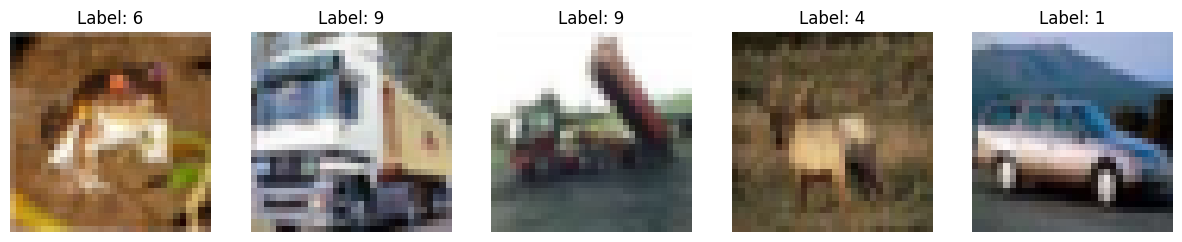

In [6]:
# 显示一些图像样本
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # 将形状从 (C, H, W) 转换为 (H, W, C)
        axes[i].imshow(image.numpy() * 0.5 + 0.5)  # 反归一化
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# 显示前5张图像
show_images(train_dataset)

In [7]:
class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [8]:
dip_model = DIP()
optimizer_dip = torch.optim.Adam(dip_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

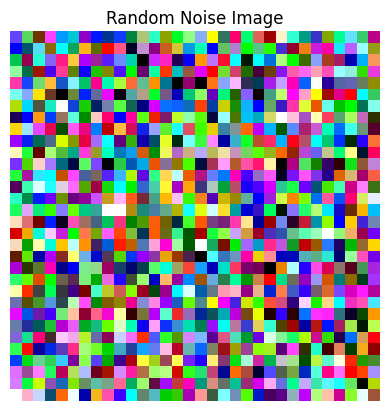

In [9]:
# 输入随机噪声图像
noise_image = torch.randn((1, 3, 32, 32))

plt.imshow(noise_image[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title('Random Noise Image')
plt.axis('off')
plt.show()

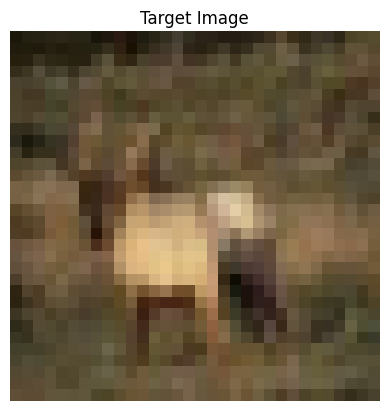

In [10]:
# 从数据集中获取一个目标图像
target_image, _ = train_dataset[3]  # 取第一个样本作为目标图像
target_image = target_image.unsqueeze(0)  # 增加一个batch维度

# 显示目标图像
plt.imshow(target_image[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title('Target Image')
plt.axis('off')
plt.show()

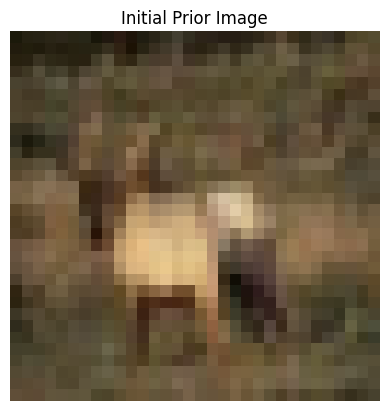

In [11]:
# 训练DIP模型
for epoch in range(2500):  # 训练的轮数可以根据实际情况调整
    optimizer_dip.zero_grad()
    output = dip_model(noise_image)
    loss = criterion(output, target_image)
    loss.backward()
    optimizer_dip.step()

# 生成初始先验图像
initial_prior = dip_model(noise_image).detach()

# 显示初始先验图像
plt.imshow(initial_prior[0].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
plt.title('Initial Prior Image')
plt.axis('off')
plt.show()

In [12]:
ddpm_model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4)
)

# 定义Gaussian Diffusion模型
diffusion = GaussianDiffusion(
    ddpm_model,
    image_size = 32,
    timesteps = 100,    # 扩散步骤数
    sampling_timesteps = 25    # 采样步骤数 (使用ddim加速推理)
)

In [13]:
# 将初始先验图像扩展为适当的形状
initial_prior_expanded = initial_prior.repeat(batch_size, 1, 1, 1)

# 定义优化器
optimizer_ddpm = torch.optim.Adam(ddpm_model.parameters(), lr=learning_rate)

Epoch 1/15: 100%|██████████| 125/125 [01:23<00:00,  1.50it/s, Loss=0.352]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

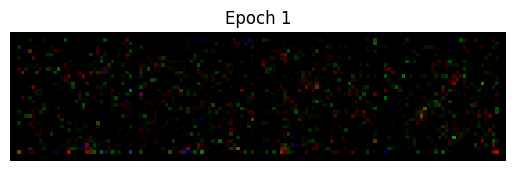

<ipython-input-14-ac12f38ffb06>:39: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(target_image_resized_np, sample_image_np, multichannel=True, data_range=1)


Epoch [1/15], PSNR: 6.3823, SSIM: -0.0049


Epoch 2/15: 100%|██████████| 125/125 [01:22<00:00,  1.52it/s, Loss=0.132]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

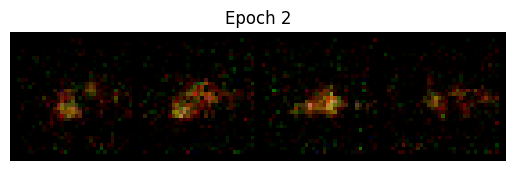

Epoch [2/15], PSNR: 6.6025, SSIM: 0.0016


Epoch 3/15: 100%|██████████| 125/125 [01:22<00:00,  1.52it/s, Loss=0.00983]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

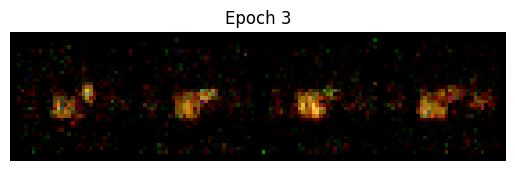

Epoch [3/15], PSNR: 6.6367, SSIM: -0.0105


Epoch 4/15: 100%|██████████| 125/125 [01:21<00:00,  1.53it/s, Loss=0.0172]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

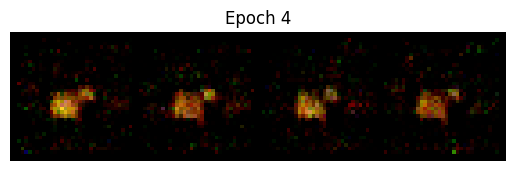

Epoch [4/15], PSNR: 6.7217, SSIM: -0.0054


Epoch 5/15: 100%|██████████| 125/125 [01:21<00:00,  1.53it/s, Loss=0.0224]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

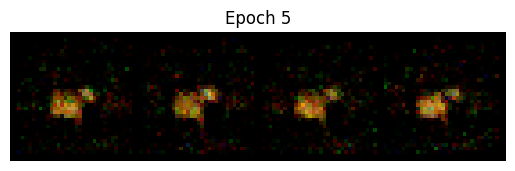

Epoch [5/15], PSNR: 6.7228, SSIM: -0.0111


Epoch 6/15: 100%|██████████| 125/125 [01:21<00:00,  1.53it/s, Loss=0.121]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

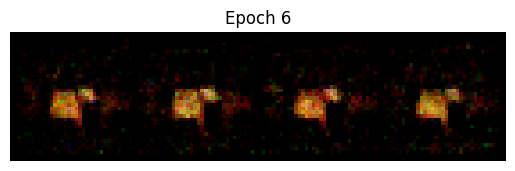

Epoch [6/15], PSNR: 6.7470, SSIM: -0.0335


Epoch 7/15: 100%|██████████| 125/125 [01:21<00:00,  1.53it/s, Loss=0.0159]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

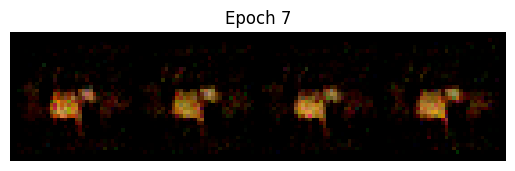

Epoch [7/15], PSNR: 6.7598, SSIM: -0.0352


Epoch 8/15: 100%|██████████| 125/125 [01:21<00:00,  1.53it/s, Loss=0.00351]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

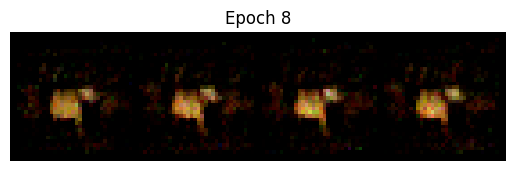

Epoch [8/15], PSNR: 6.7531, SSIM: -0.0463


Epoch 9/15: 100%|██████████| 125/125 [01:21<00:00,  1.54it/s, Loss=0.00933]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

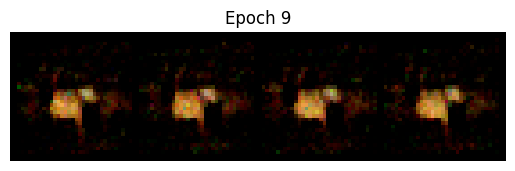

Epoch [9/15], PSNR: 6.7208, SSIM: -0.0681


Epoch 10/15: 100%|██████████| 125/125 [01:21<00:00,  1.53it/s, Loss=0.00921]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

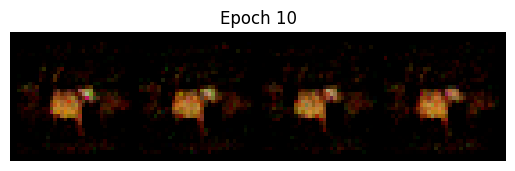

Epoch [10/15], PSNR: 6.7483, SSIM: -0.0553


Epoch 11/15: 100%|██████████| 125/125 [01:21<00:00,  1.54it/s, Loss=0.00859]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

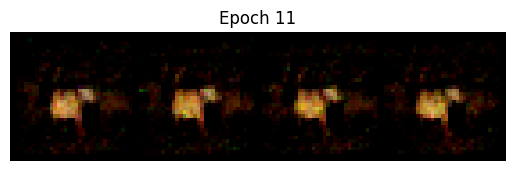

Epoch [11/15], PSNR: 6.7316, SSIM: -0.0631


Epoch 12/15: 100%|██████████| 125/125 [01:21<00:00,  1.54it/s, Loss=0.0155]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

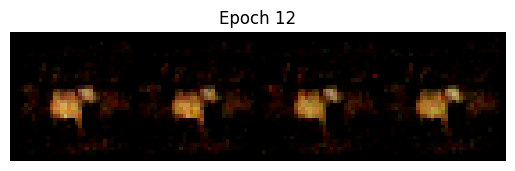

Epoch [12/15], PSNR: 6.7365, SSIM: -0.0645


Epoch 13/15: 100%|██████████| 125/125 [01:22<00:00,  1.52it/s, Loss=0.00586]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

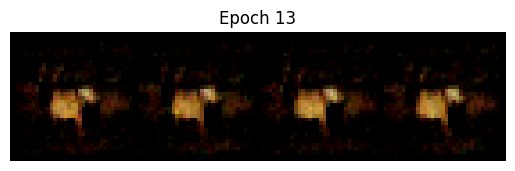

Epoch [13/15], PSNR: 6.7321, SSIM: -0.0722


Epoch 14/15: 100%|██████████| 125/125 [01:20<00:00,  1.56it/s, Loss=0.00955]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

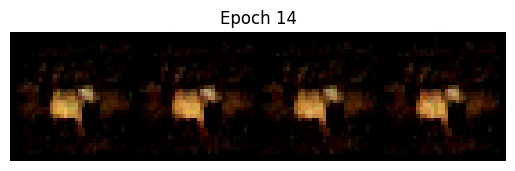

Epoch [14/15], PSNR: 6.6855, SSIM: -0.0943


Epoch 15/15: 100%|██████████| 125/125 [01:18<00:00,  1.58it/s, Loss=0.0109]


sampling loop time step:   0%|          | 0/25 [00:00<?, ?it/s]

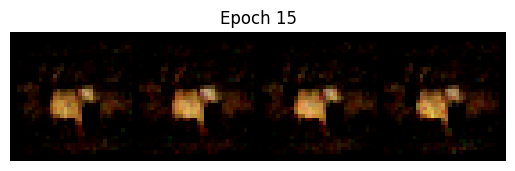

Epoch [15/15], PSNR: 6.7230, SSIM: -0.0778
Total training time: 1304.69 seconds


In [14]:
# 開始計時
start_time = time.time()

# 訓練循環
for epoch in range(num_epochs):
    with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
        for batch_idx, batch in enumerate(train_dataloader):
            optimizer_ddpm.zero_grad()

            # 使用dip結果作爲輸入
            # initial_prior_noisy = initial_prior_expanded + torch.randn_like(initial_prior_expanded) * 0.05
            initial_prior_noisy = initial_prior_expanded

            # forward process
            loss = diffusion(initial_prior_noisy)

            # backward process
            loss.backward()
            optimizer_ddpm.step()

            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

    with torch.no_grad():
        sample_images = diffusion.sample(batch_size=batch_size)
        grid = torchvision.utils.make_grid(sample_images, nrow=4)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f'Epoch {epoch+1}')
        plt.axis('off')
        plt.show()

        target_image_resized = transforms.Resize((image_size, image_size))(target_image)

        # 计算评估指标
        target_image_resized_np = target_image_resized.squeeze().permute(1, 2, 0).numpy()
        sample_image_np = sample_images[0].permute(1, 2, 0).cpu().numpy()

        psnr = peak_signal_noise_ratio(target_image_resized_np, sample_image_np, data_range=1)
        ssim = structural_similarity(target_image_resized_np, sample_image_np, multichannel=True, data_range=1)

        print(f"Epoch [{epoch+1}/{num_epochs}], PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")

# 結束計時
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")